<a href="https://www.kaggle.com/code/vanpatangan/supply-chain-in-healthcare?scriptVersionId=209881881" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Load datasets
inventory_df = pd.read_csv('/kaggle/input/hospital-supply-chain/inventory_data.csv')
patient_df = pd.read_csv('/kaggle/input/hospital-supply-chain/patient_data.csv')
staff_df = pd.read_csv('/kaggle/input/hospital-supply-chain/staff_data.csv')
financial_df = pd.read_csv('/kaggle/input/hospital-supply-chain/financial_data.csv')

sns.set_theme(style="whitegrid", palette="pastel")

# Data Summary

In [2]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Use list comprehension to iterate over each column
    summary = [
        [col, df[col].dtype, df[col].count(), df[col].nunique(), df[col].isnull().sum(), df.duplicated().sum()]
        for col in df.columns
    ]

    # Create a DataFrame from the list of lists
    df_check = pd.DataFrame(summary, columns=["column", "dtype", "instances", "unique", "sum_null", "duplicates"])

    return df_check

In [3]:
print("Inventory Data Summary")
display(check(inventory_df))
display(inventory_df.head())
print("Patient Data Summary")
display(check(patient_df))
display(patient_df.head())
print("Staff Data Summary")
display(check(staff_df))
display(staff_df.head())
print("Financial Data Summary")
display(check(financial_df))
display(financial_df.head())

Inventory Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,Date,object,500,500,0,0
1,Item_ID,int64,500,10,0,0
2,Item_Type,object,500,2,0,0
3,Item_Name,object,500,5,0,0
4,Current_Stock,int64,500,475,0,0
5,Min_Required,int64,500,393,0,0
6,Max_Capacity,int64,500,480,0,0
7,Unit_Cost,float64,500,500,0,0
8,Avg_Usage_Per_Day,int64,500,317,0,0
9,Restock_Lead_Time,int64,500,29,0,0


,Date,Item_ID,Item_Type,Item_Name,Current_Stock,Min_Required,Max_Capacity,Unit_Cost,Avg_Usage_Per_Day,Restock_Lead_Time,Vendor_ID
0,2024-10-01,105,Consumable,Ventilator,1542,264,1018,4467.55,108,17,V001
1,2024-10-02,100,Equipment,Ventilator,2487,656,3556,5832.29,55,12,V001
2,2024-10-03,103,Equipment,Surgical Mask,2371,384,5562,16062.98,470,6,V001
3,2024-10-04,103,Consumable,Surgical Mask,2038,438,1131,744.10,207,15,V002
4,2024-10-05,107,Equipment,IV Drip,2410,338,1013,15426.53,158,12,V003


Patient Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,Patient_ID,object,500,500,0,0
1,Admission_Date,object,500,500,0,0
2,Discharge_Date,object,500,500,0,0
3,Primary_Diagnosis,object,500,4,0,0
4,Procedure_Performed,object,500,4,0,0
5,Room_Type,object,500,2,0,0
6,Bed_Days,int64,500,14,0,0
7,Supplies_Used,object,500,3,0,0
8,Equipment_Used,object,500,3,0,0
9,Staff_Needed,object,500,3,0,0


,Patient_ID,Admission_Date,Discharge_Date,Primary_Diagnosis,Procedure_Performed,Room_Type,Bed_Days,Supplies_Used,Equipment_Used,Staff_Needed
0,P001,2024-10-06 05:30:28,2024-10-23 01:11:34,Diabetes,Appendectomy,General Ward,2,"Gloves, IV",Surgical Table,2 Surgeons
1,P002,2024-10-24 11:07:58,2024-10-15 05:16:54,Fracture,Appendectomy,ICU,10,"Gown, IV",MRI Machine,1 Nurse
2,P003,2024-10-22 21:43:43,2024-10-24 10:56:30,Fracture,Chest X-ray,ICU,10,"Gloves, IV",X-ray Machine,"1 Nurse, 1 Doctor"
3,P004,2024-10-05 17:04:05,2024-10-30 14:10:01,Diabetes,Chest X-ray,ICU,11,"Gloves, IV",X-ray Machine,1 Nurse
4,P005,2024-10-21 17:04:00,2024-10-08 15:53:22,Appendicitis,MRI,ICU,2,"Gloves, IV",X-ray Machine,2 Surgeons


Staff Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,Staff_ID,object,500,500,0,0
1,Staff_Type,object,500,3,0,0
2,Shift_Date,object,500,500,0,0
3,Shift_Start_Time,object,500,3,0,0
4,Shift_End_Time,object,500,3,0,0
5,Current_Assignment,object,500,3,0,0
6,Hours_Worked,int64,500,4,0,0
7,Patients_Assigned,int64,500,9,0,0
8,Overtime_Hours,int64,500,5,0,0


,Staff_ID,Staff_Type,Shift_Date,Shift_Start_Time,Shift_End_Time,Current_Assignment,Hours_Worked,Patients_Assigned,Overtime_Hours
0,S001,Surgeon,2024-10-22 04:44:49,06:00 PM,07:00 PM,ER,8,9,1
1,S002,Nurse,2024-10-03 05:51:36,08:00 AM,06:00 PM,General Ward,9,3,0
2,S003,Technician,2024-10-15 15:11:14,08:00 AM,06:00 PM,ER,8,6,4
3,S004,Surgeon,2024-10-09 20:07:58,07:00 AM,06:00 PM,General Ward,11,6,3
4,S005,Surgeon,2024-10-12 05:01:02,07:00 AM,06:00 AM,General Ward,9,5,3


Financial Data Summary


,column,dtype,instances,unique,sum_null,duplicates
0,Date,object,500,500,0,0
1,Expense_Category,object,500,3,0,0
2,Amount,float64,500,500,0,0
3,Description,object,500,3,0,0


,Date,Expense_Category,Amount,Description
0,2024-10-01,Staffing,29391.86,Surgical masks
1,2024-10-02,Supplies,47757.71,Surgical masks
2,2024-10-03,Supplies,43996.60,Ventilators
3,2024-10-04,Supplies,27908.42,Surgeons' salaries
4,2024-10-05,Equipment,39719.60,Ventilators


In [4]:
# Rename Date columns for distinction
inventory_df = inventory_df.rename(columns={'Date': 'Inventory_Date'})
financial_df = financial_df.rename(columns={'Date': 'Financial_Date'})

# Convert date columns to datetime
inventory_df['Inventory_Date'] = pd.to_datetime(inventory_df['Inventory_Date'])
patient_df['Admission_Date'] = pd.to_datetime(patient_df['Admission_Date'])
patient_df['Discharge_Date'] = pd.to_datetime(patient_df['Discharge_Date'])
staff_df['Shift_Date'] = pd.to_datetime(staff_df['Shift_Date'])
financial_df['Financial_Date'] = pd.to_datetime(financial_df['Financial_Date'])

# Combine dataframes
combined_df = pd.concat([inventory_df, patient_df, staff_df, financial_df], axis=1)
combined_df.fillna(0, inplace=True)  # Fill NaNs with 0

# Visualization

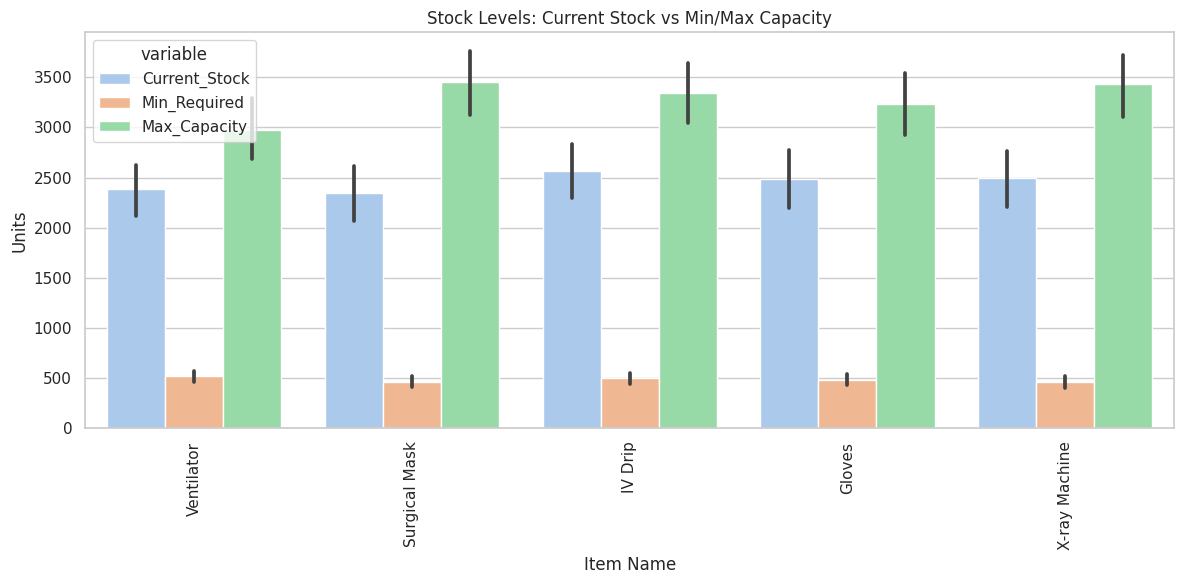

In [5]:
# Data for Current_Stock vs Min_Required and Max_Capacity
plt.figure(figsize=(12, 6))
combined_df_melted = combined_df.melt(id_vars=["Item_Name"], value_vars=["Current_Stock", "Min_Required", "Max_Capacity"])

# Bar plot for stock levels
sns.barplot(x='Item_Name', y='value', hue='variable', data=combined_df_melted)
plt.xticks(rotation=90)
plt.title('Stock Levels: Current Stock vs Min/Max Capacity')
plt.ylabel('Units')
plt.xlabel('Item Name')
plt.tight_layout()
plt.show()

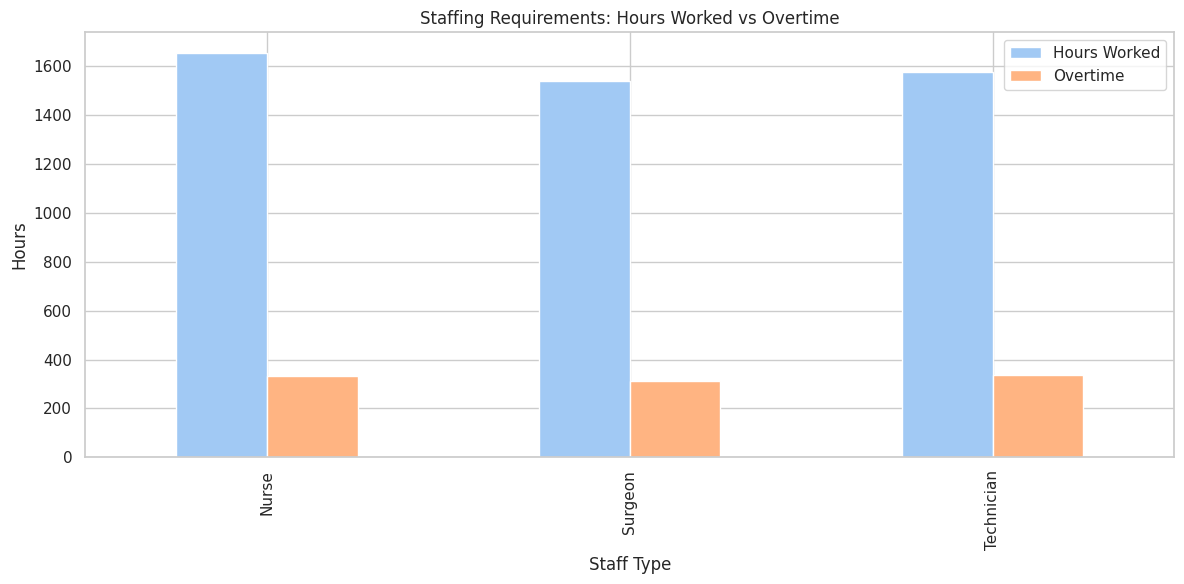

In [6]:
# Grouped bar chart for staffing requirements vs hours worked
staff_df = combined_df.groupby('Staff_Type').agg({'Hours_Worked': 'sum', 'Overtime_Hours': 'sum'}).reset_index()
staff_df.plot(x='Staff_Type', kind='bar', stacked=False, figsize=(12, 6))
plt.title('Staffing Requirements: Hours Worked vs Overtime')
plt.ylabel('Hours')
plt.xlabel('Staff Type')
plt.legend(['Hours Worked', 'Overtime'])
plt.tight_layout()
plt.show()

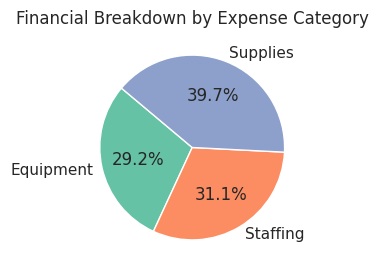

In [7]:
# Pie chart for financial expenses by category
expense_df = combined_df.groupby('Expense_Category').agg({'Amount': 'sum'}).reset_index()
plt.figure(figsize=(3, 3))
plt.pie(expense_df['Amount'], labels=expense_df['Expense_Category'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('Financial Breakdown by Expense Category')
plt.show()

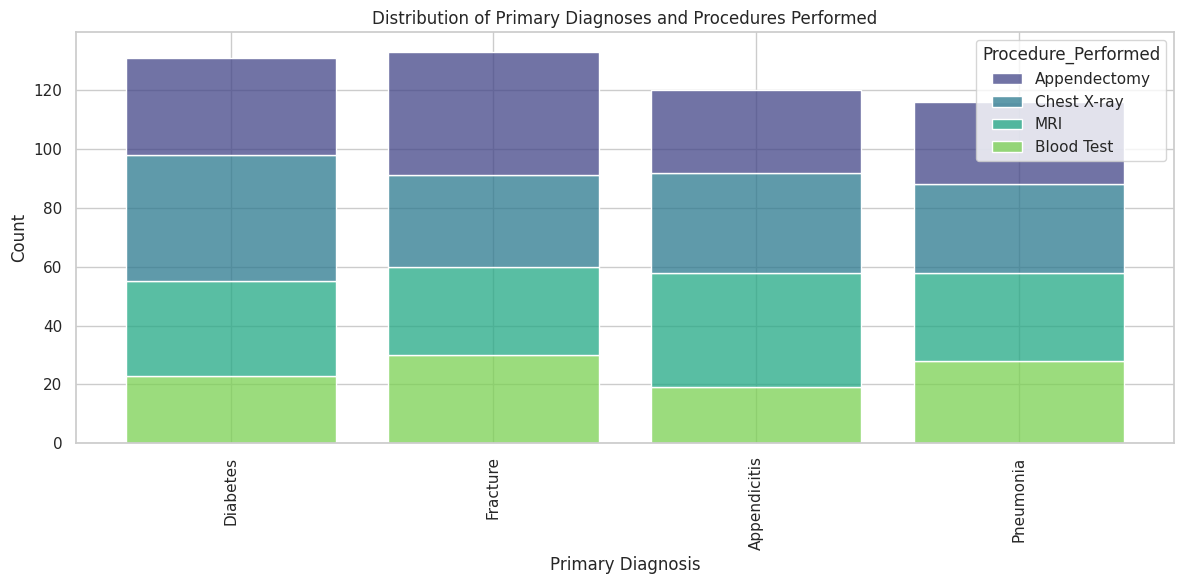

In [8]:
# Stacked bar chart for patient diagnosis and procedures
plt.figure(figsize=(12, 6))
sns.histplot(data=combined_df, x='Primary_Diagnosis', hue='Procedure_Performed', multiple='stack', shrink=0.8, palette='viridis')
plt.xticks(rotation=90)
plt.title('Distribution of Primary Diagnoses and Procedures Performed')
plt.ylabel('Count')
plt.xlabel('Primary Diagnosis')
plt.tight_layout()
plt.show()

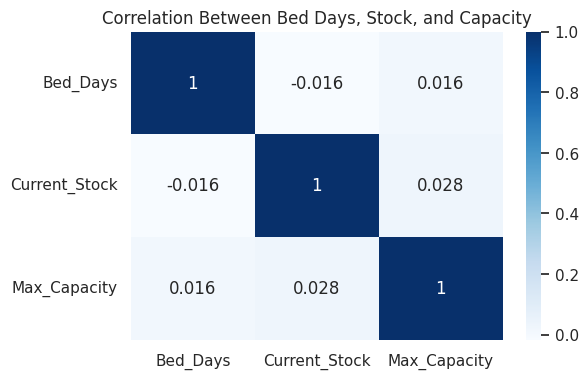

In [9]:
# Heatmap for correlation between bed days and supplies/equipment usage
correlation_df = combined_df[['Bed_Days', 'Current_Stock', 'Max_Capacity']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_df, annot=True, cmap='Blues')
plt.title('Correlation Between Bed Days, Stock, and Capacity')
plt.show()

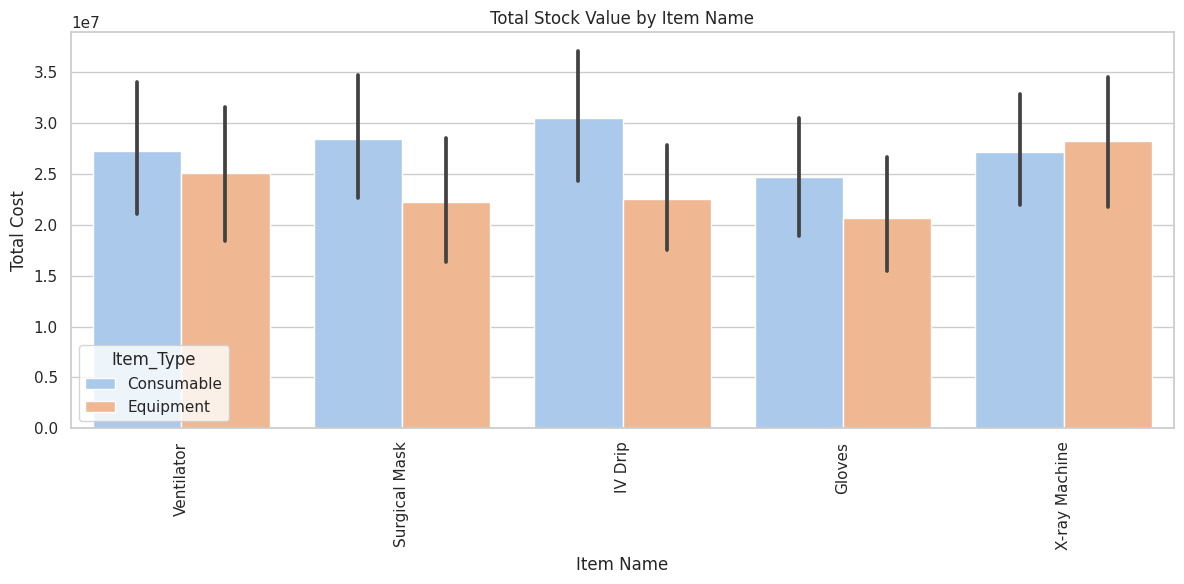

In [10]:
# Bar chart for inventory cost analysis
combined_df['Total_Stock_Value'] = combined_df['Current_Stock'] * combined_df['Unit_Cost']
plt.figure(figsize=(12, 6))
sns.barplot(x='Item_Name', y='Total_Stock_Value', hue='Item_Type', data=combined_df)
plt.xticks(rotation=90)
plt.title('Total Stock Value by Item Name')
plt.ylabel('Total Cost')
plt.xlabel('Item Name')
plt.tight_layout()
plt.show()

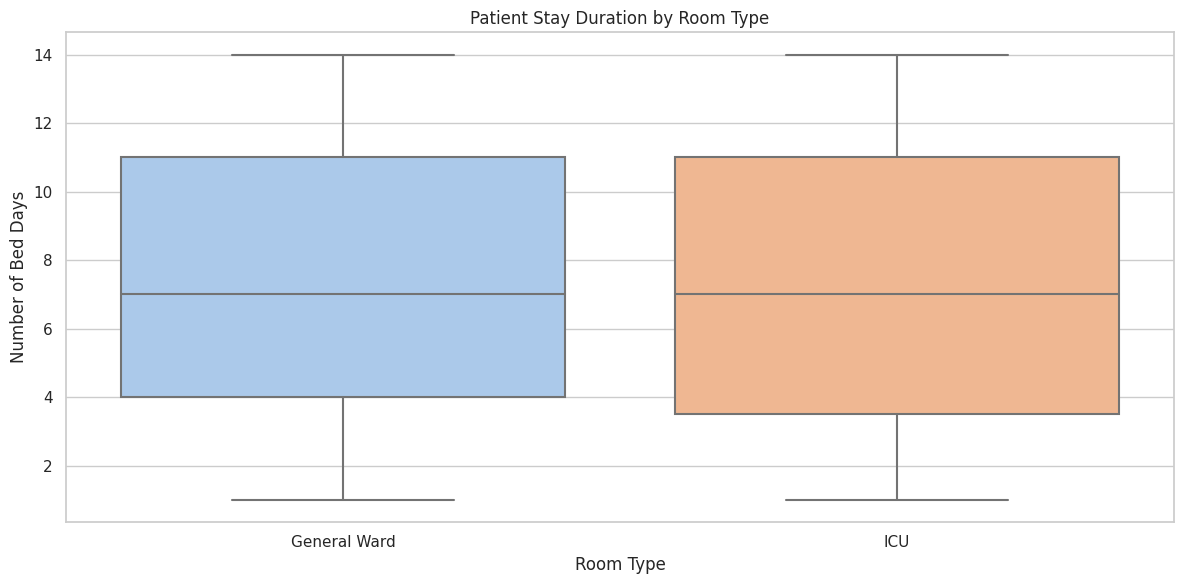

In [11]:
# Box plot for patient stay duration analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x='Room_Type', y='Bed_Days', data=combined_df)
plt.title('Patient Stay Duration by Room Type')
plt.ylabel('Number of Bed Days')
plt.xlabel('Room Type')
plt.tight_layout()
plt.show()

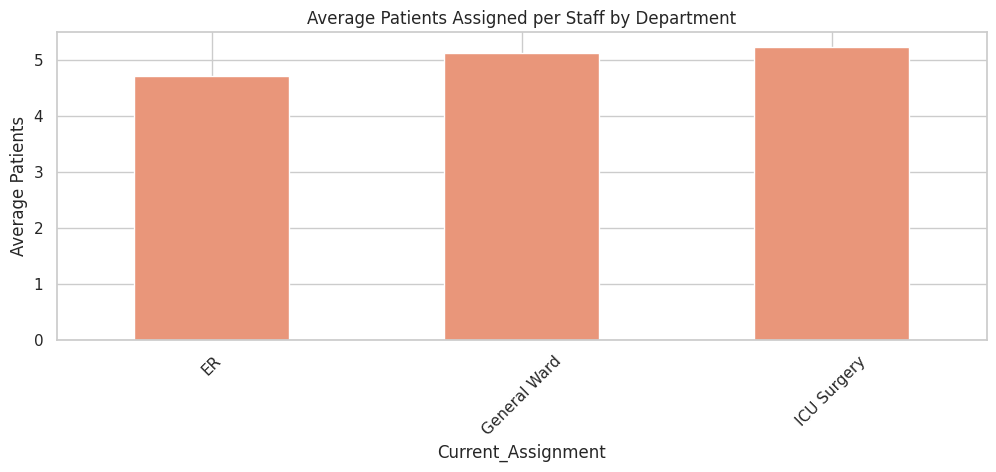

In [12]:
# Average number of patients assigned to staff in different hospital areas
plt.figure(figsize=(12, 4))
combined_df.groupby('Current_Assignment')['Patients_Assigned'].mean().plot(kind='bar', color='darksalmon')
plt.title('Average Patients Assigned per Staff by Department')
plt.ylabel('Average Patients')
plt.xticks(rotation=45)
plt.show()

# Feature Engineering

In [13]:
# Calculate Remaining Stock Percentage (Current Stock vs Max Capacity)
combined_df['Stock_Percentage'] = (combined_df['Current_Stock'] / combined_df['Max_Capacity']) * 100

# Calculate Days to Stockout (using Avg Usage Per Day)
combined_df['Days_To_Stockout'] = combined_df['Current_Stock'] / combined_df['Avg_Usage_Per_Day']

# Create a feature for how close stock is to the minimum required
combined_df['Below_Min_Stock'] = combined_df['Current_Stock'] < combined_df['Min_Required']

# Binary feature for whether or not a procedure was performed
combined_df['Procedure_Performed_Flag'] = combined_df['Procedure_Performed'].notnull()

# Days spent by patients in assigned beds
combined_df['Total_Bed_Days'] = combined_df['Bed_Days'] * combined_df['Patients_Assigned']

# Days in Hospital
combined_df['Days_in_Hospital'] = (combined_df['Discharge_Date'] - combined_df['Admission_Date']).dt.days

# Shift Duration
combined_df['Shift_Duration'] = (pd.to_datetime(combined_df['Shift_End_Time']) - 
                                     pd.to_datetime(combined_df['Shift_Start_Time'])).dt.total_seconds() / 3600
# Overtime Ratio
combined_df['Overtime_Ratio'] = combined_df['Overtime_Hours'] / (combined_df['Hours_Worked'] + combined_df['Overtime_Hours'])

# Cost per Day
combined_df['Cost_per_Day'] = combined_df['Unit_Cost'] * combined_df['Avg_Usage_Per_Day']


# Create a Target Variable
combined_df['Estimated_Demand'] = combined_df['Avg_Usage_Per_Day'] * combined_df['Restock_Lead_Time']

# Encoding

In [14]:
# Identify columns with object dtype
object_columns = combined_df.select_dtypes(include=['object']).columns
    
# One-hot encode the object columns
combined_df_encoded = pd.get_dummies(combined_df, columns=object_columns, drop_first=True)
combined_df_encoded.fillna(0, inplace=True)  # Fill NaNs with 0

# Modeling

Validation Mean Absolute Error: 228.500180268004
Test Mean Absolute Error: 163.09590610272534


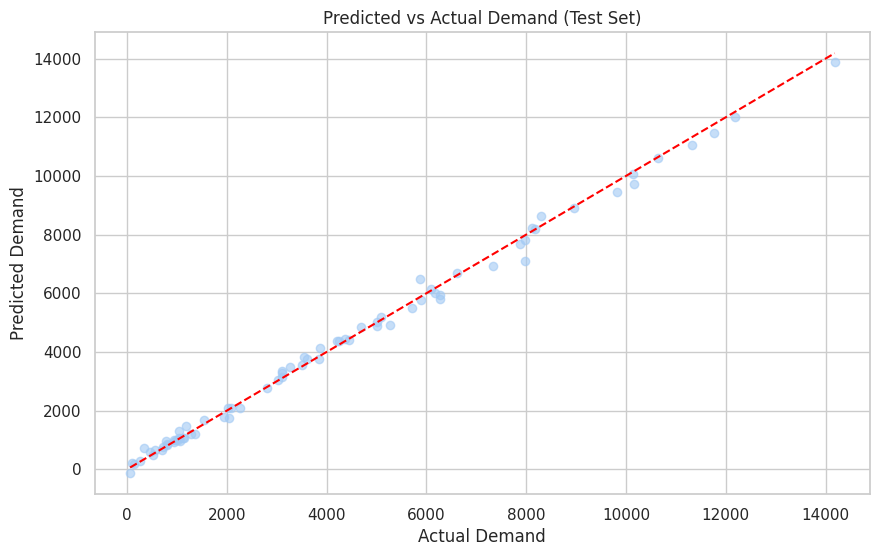

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error


# Target variable
y = combined_df_encoded['Estimated_Demand']

# Drop target and non-relevant columns from the feature set
X = combined_df_encoded.drop(['Estimated_Demand', 'Inventory_Date', 'Admission_Date', 
                              'Discharge_Date', 'Shift_Date', 'Financial_Date'], axis=1)

# Split data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test

# Train the Gradient Boosting Regressor
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Validate the model
y_val_pred = model.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
print(f"Validation Mean Absolute Error: {val_mae}")

# Test the model
y_test_pred = model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
print(f"Test Mean Absolute Error: {test_mae}")

# Visualize predictions vs actual for the test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.title('Predicted vs Actual Demand (Test Set)')
plt.show()
